# IBM Dynamical Decoupling Optimizations with Superstaq

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Infleqtion/client-superstaq/blob/main/docs/source/optimizations/ibm/ibmq_dd.ipynb) [![Launch Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Infleqtion/client-superstaq/HEAD?labpath=docs/source/optimizations/ibm/ibmq_dd.ipynb)

[Dynamical decoupling (DD)](https://arxiv.org/abs/quant-ph/9803057) is an error mitigation technique used to suppress noise added to computation from system-environment interaction (i.e. decoherence error). DD is implemented during algorithm execution by adding special gate sequences that are equal to the identity operation in periods of qubit idling. Examples of DD sequences include XX, XY4, XY8, and UDD, among others.

Below is a brief tutorial on Superstaq dynamical decoupling optimizations for the IBM family of superconducting quantum devices. In the example, the CPMG sequence, XX, will be used. CPMG is our default DD strategy.

Many [research articles](https://arxiv.org/abs/2207.03670) can be found that describe the variations and benefits of DD. For more information about IBM Quantum, visit their website [here](https://quantum-computing.ibm.com/).


## Imports and API Token

This example tutorial notebook uses `qiskit-superstaq`, our Superstaq client for Qiskit; you can try it out by running `pip install qiskit-superstaq`.

In [1]:
# Required Superstaq imports
try:
    import qiskit
    import qiskit_superstaq as qss
except ImportError:
    print("Installing qiskit-superstaq...")
    %pip install -q qiskit-superstaq[examples]
    print("Installed qiskit-superstaq. Please restart the kernel to import the packages.")

# Optional imports
import os  # used if setting a token as an environment variable

To interface Superstaq via Qiskit, we must first instantiate a provider in `qiskit-superstaq` with `SuperstaqProvider()`. We then supply a Superstaq API token (or key) by either providing the API token as an argument of `qss.SuperstaqProvider()` or by setting it as an environment variable (see more details [here](https://superstaq.readthedocs.io/en/latest/get_started/basics/basics_qss.html#Set-up-access-to-Superstaq%E2%80%99s-API)).

In [2]:
# Get the qiskit superstaq provider for Superstaq backend
# Provide your api key to the using the "api_key" argument if
# SUPERSTAQ_API_KEY environment variable is not set.
provider = qss.SuperstaqProvider()

This notebook will target IBM's 16-qubit Guadalupe device.

In [3]:
backend = provider.get_backend("ibmq_guadalupe_qpu")

To submit jobs to the IBM machine, we will use an `IBMProvider`. This will require `qiskit-ibm-provider` and an accout on [IBM Quantum](https://quantum-computing.ibm.com/).

In [4]:
# Required IBMProvider imports
try:
    from qiskit_ibm_provider import IBMProvider
    
except ImportError:
    print("Installing qiskit_ibm_provider...")
    %pip install -q qiskit-ibm-provider
    print("Installed qiskit_ibm_provider. Please restart the kernel to import the packages.")


ibm_provider = IBMProvider()



In [5]:
ibm_backend = ibm_provider.get_backend("ibmq_guadalupe")

## Example 1: Circuit Compilation and DD Optimization with Superstaq

We will start by creating a circuit generator using Qiskit. In this example, we will use the Bernstein Vazirani (BV) algorithm to find the secret string of all ones ( i.e. '11...1'):

In [6]:
def create_bv(circuit_width: int):
    qc = qiskit.QuantumCircuit(circuit_width, circuit_width - 1)

    for i in range(circuit_width - 1):
        qc.h(i)
    qc.x(circuit_width - 1)
    qc.h(circuit_width - 1)

    for i in range(circuit_width - 1):
        qc.cx(i, circuit_width - 1)
    qc.barrier()

    for i in range(circuit_width):
        qc.h(i)
    for i in range(circuit_width - 1):
        qc.measure(i, i)

    return qc

We can draw the circuit using `qiskit`:

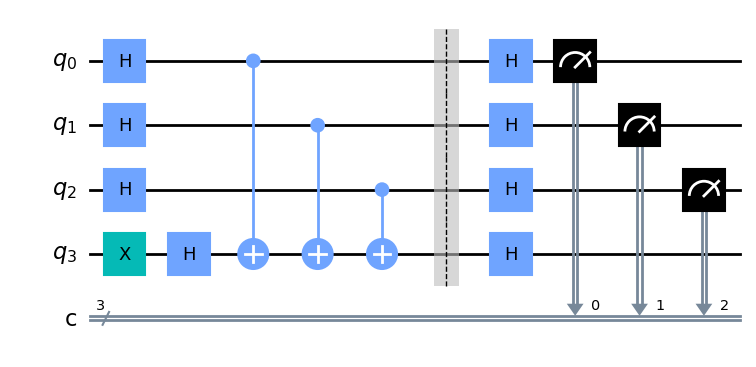

In [7]:
qc_4 = create_bv(4)
qc_4.draw("mpl")

 Next, we will compile the circuit so that it's executable on IBM Guadalupe.

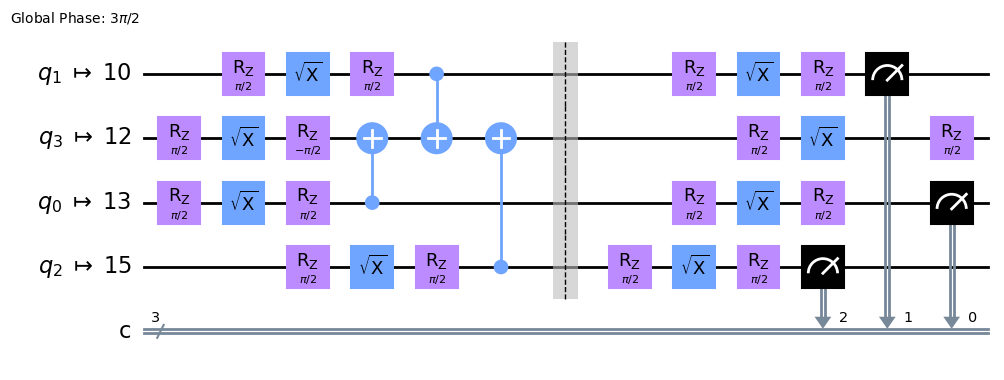

In [8]:
qc_4_optimized = qiskit.transpile(qc_4, ibm_backend, optimization_level=3)
qc_4_optimized.draw("mpl", fold=-1, idle_wires=False, justify="right")

Superstaq compilation transforms the cicuit so that it uses optimized instructions. To implement error mitigation with default `dynamic` DD, we add additional XX gates to the circuit. These are CPMG DD sequences.

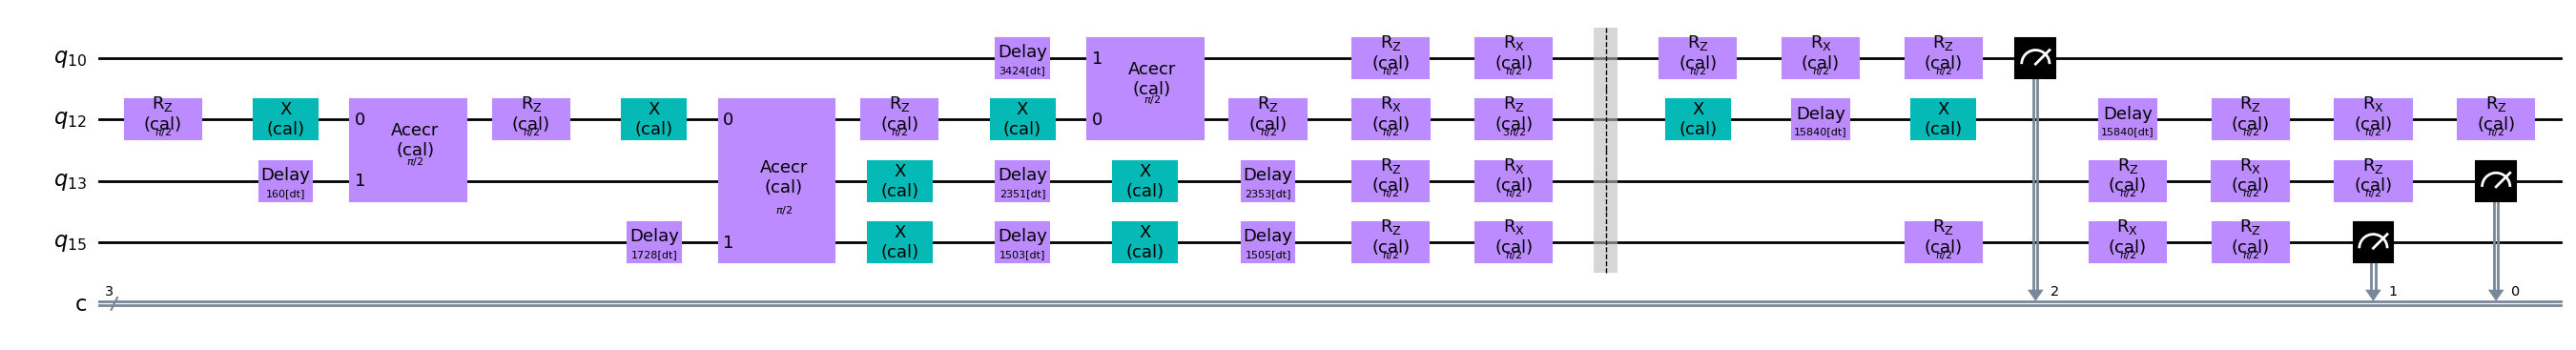

In [9]:
ss_qc_4_optimized = backend.compile(qc_4, dynamical_decoupling=True)
ss_qc_4_optimized.pulse_gate_circuit.draw("mpl", fold=-1, idle_wires=False, justify="right")

## Example 2: Real Quantum Machine Results

Here, we will show how Superstaq compares to Qiskit's `optimization_level = 3` on modestly sized circuits. First, let's create a seven-qubit BV benchmark:

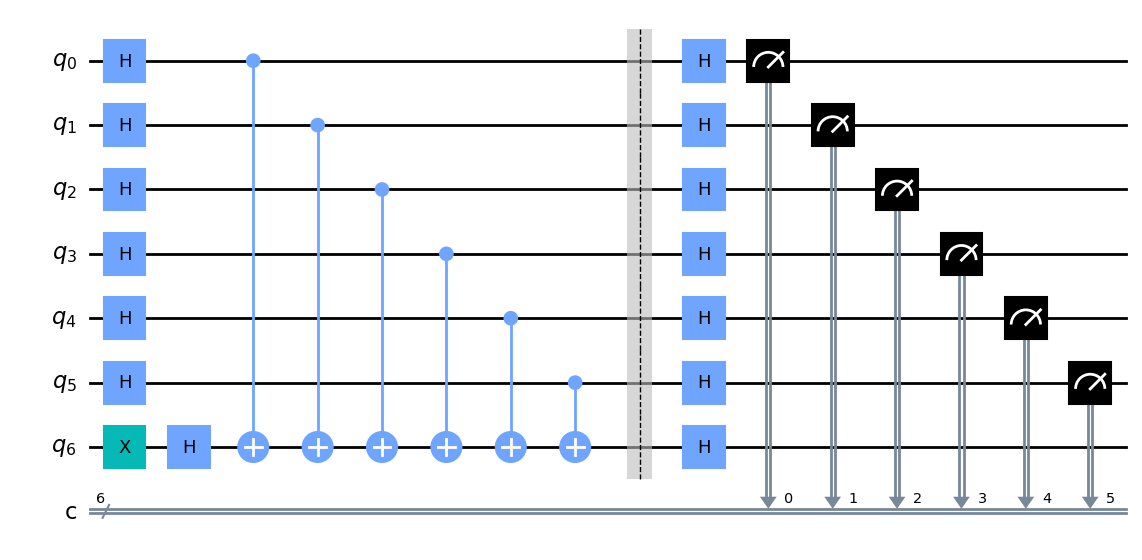

In [10]:
qc_7 = create_bv(7)
qc_7.draw("mpl")

Qiskit `optimization_level = 3` transpilation:

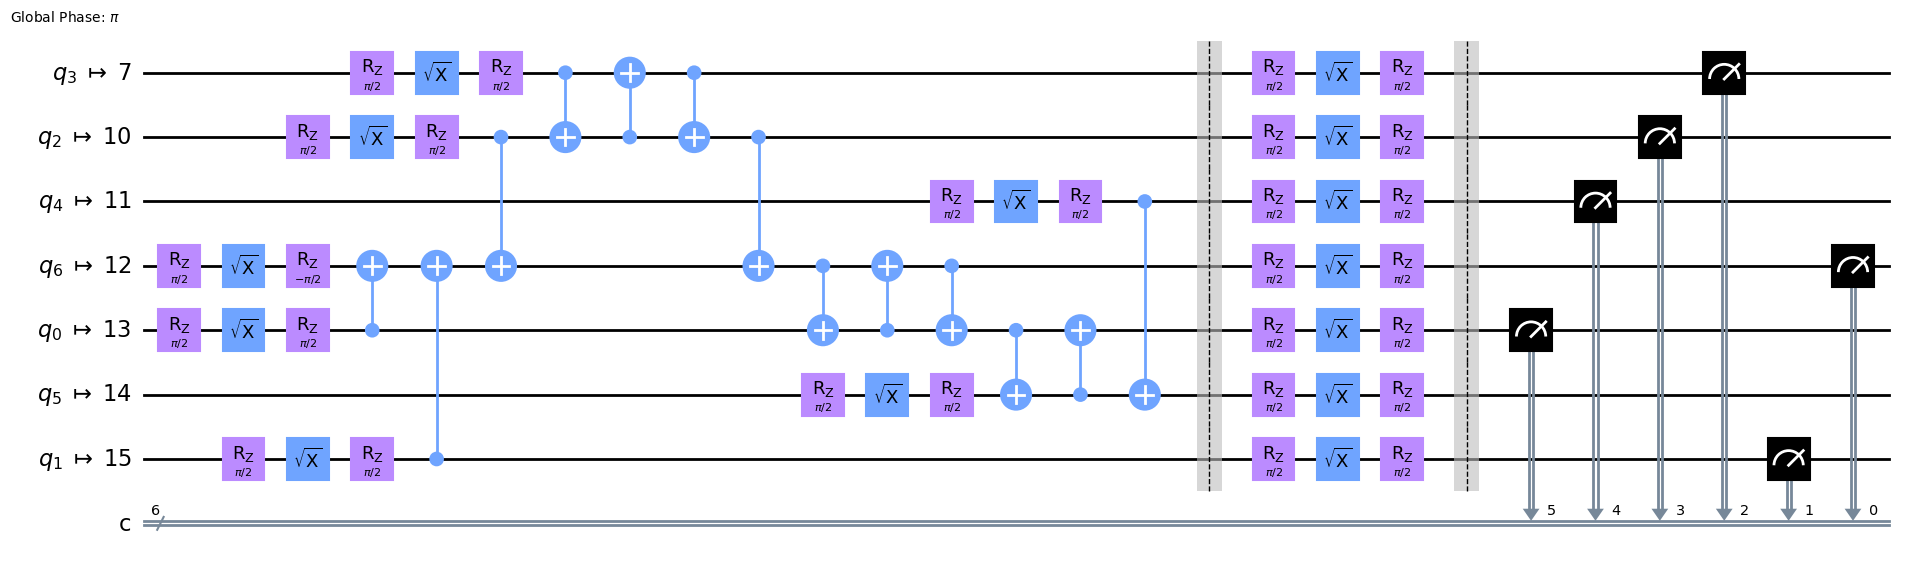

In [11]:
qc_7_optimized = qiskit.transpile(qc_7, ibm_backend, optimization_level=3)
qc_7_optimized.draw("mpl", fold=-1, idle_wires=False, justify="right")

Superstaq optimized compilation with `dynamic` DD:

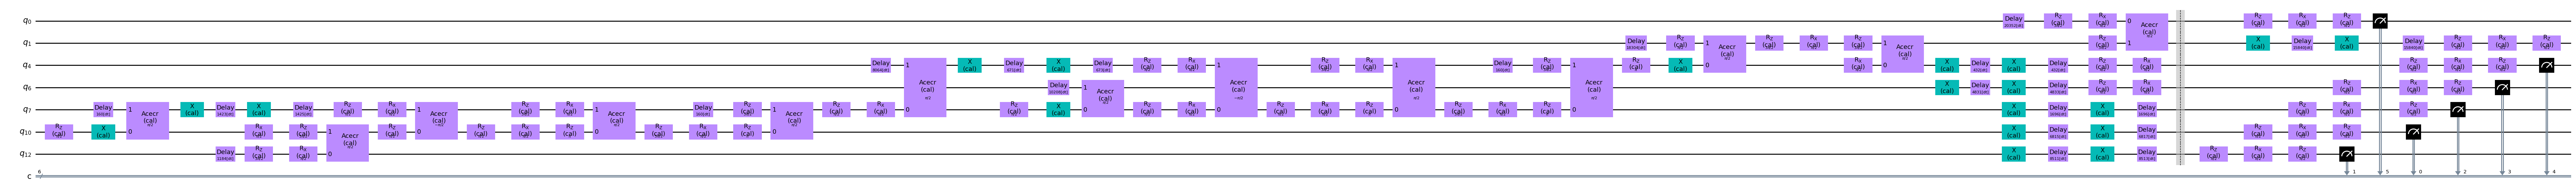

In [12]:
ss_qc_7_optimized = backend.compile(qc_7, dynamical_decoupling=True)
ss_qc_7_optimized.pulse_gate_circuit.draw("mpl", fold=-1, idle_wires=False, justify="right")

Finally, circuit execution on IBM Guadalupe:

In [21]:
job_7 = ibm_backend.run([ss_qc_7_optimized.pulse_gate_circuit,
                         qc_7_optimized], shots=4000)

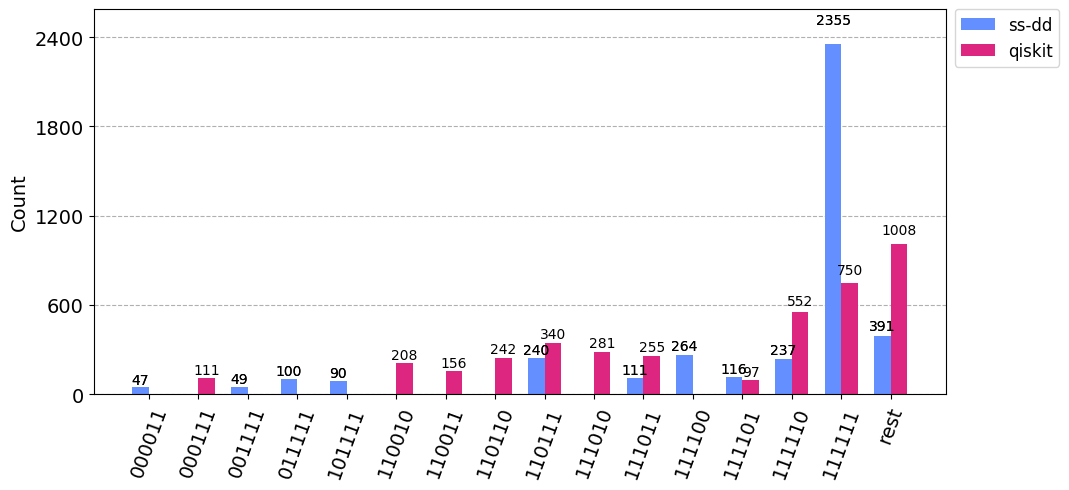

In [14]:
counts_7 = job_7.result().get_counts()
qiskit.visualization.plot_histogram(counts_7, legend=["ss-dd", "qiskit"], 
                                    number_to_keep=10,
                                    figsize=(11, 5))

The correct answer is '111111,' and we can see that Superstaq offers dramatic improvements! More than 3.1x in terms of probability of success and about 6.5x in terms of relative strength.

Let's try again with nine qubits!

First, create:

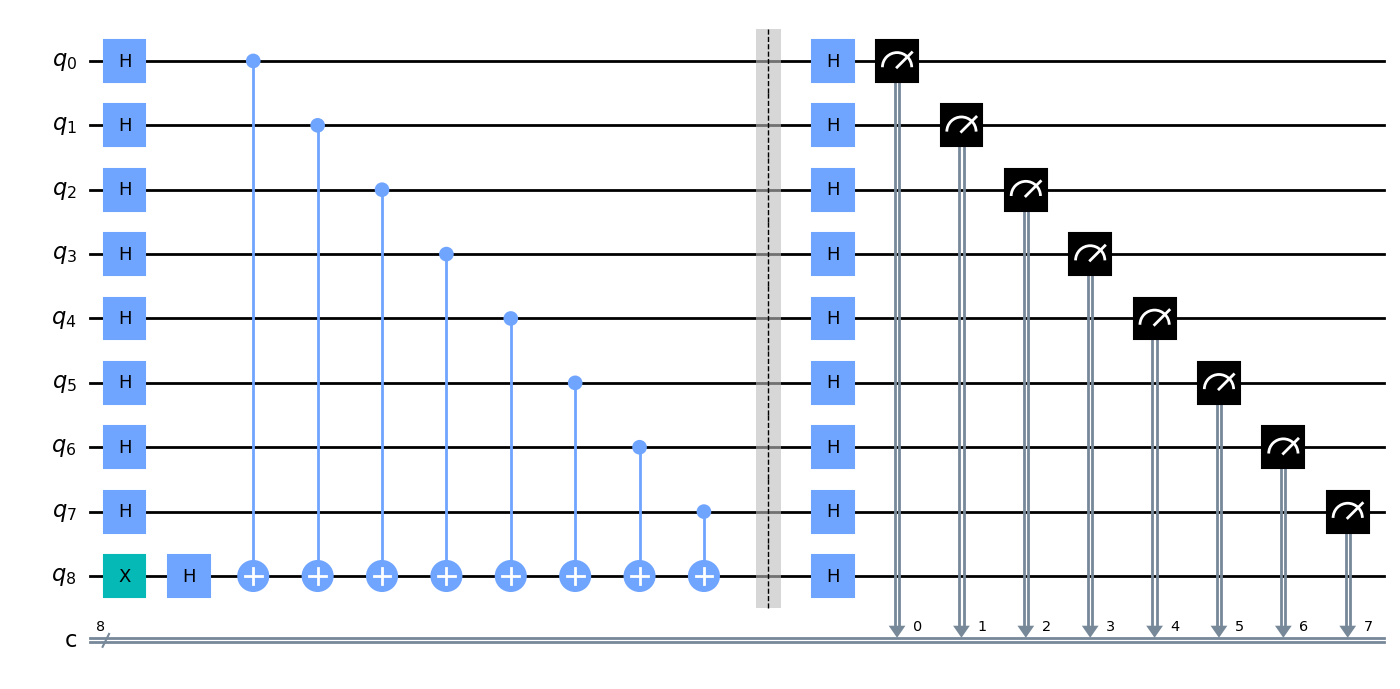

In [15]:
qc_9 = create_bv(9)
qc_9.draw("mpl")

Second, qiskit transpile:

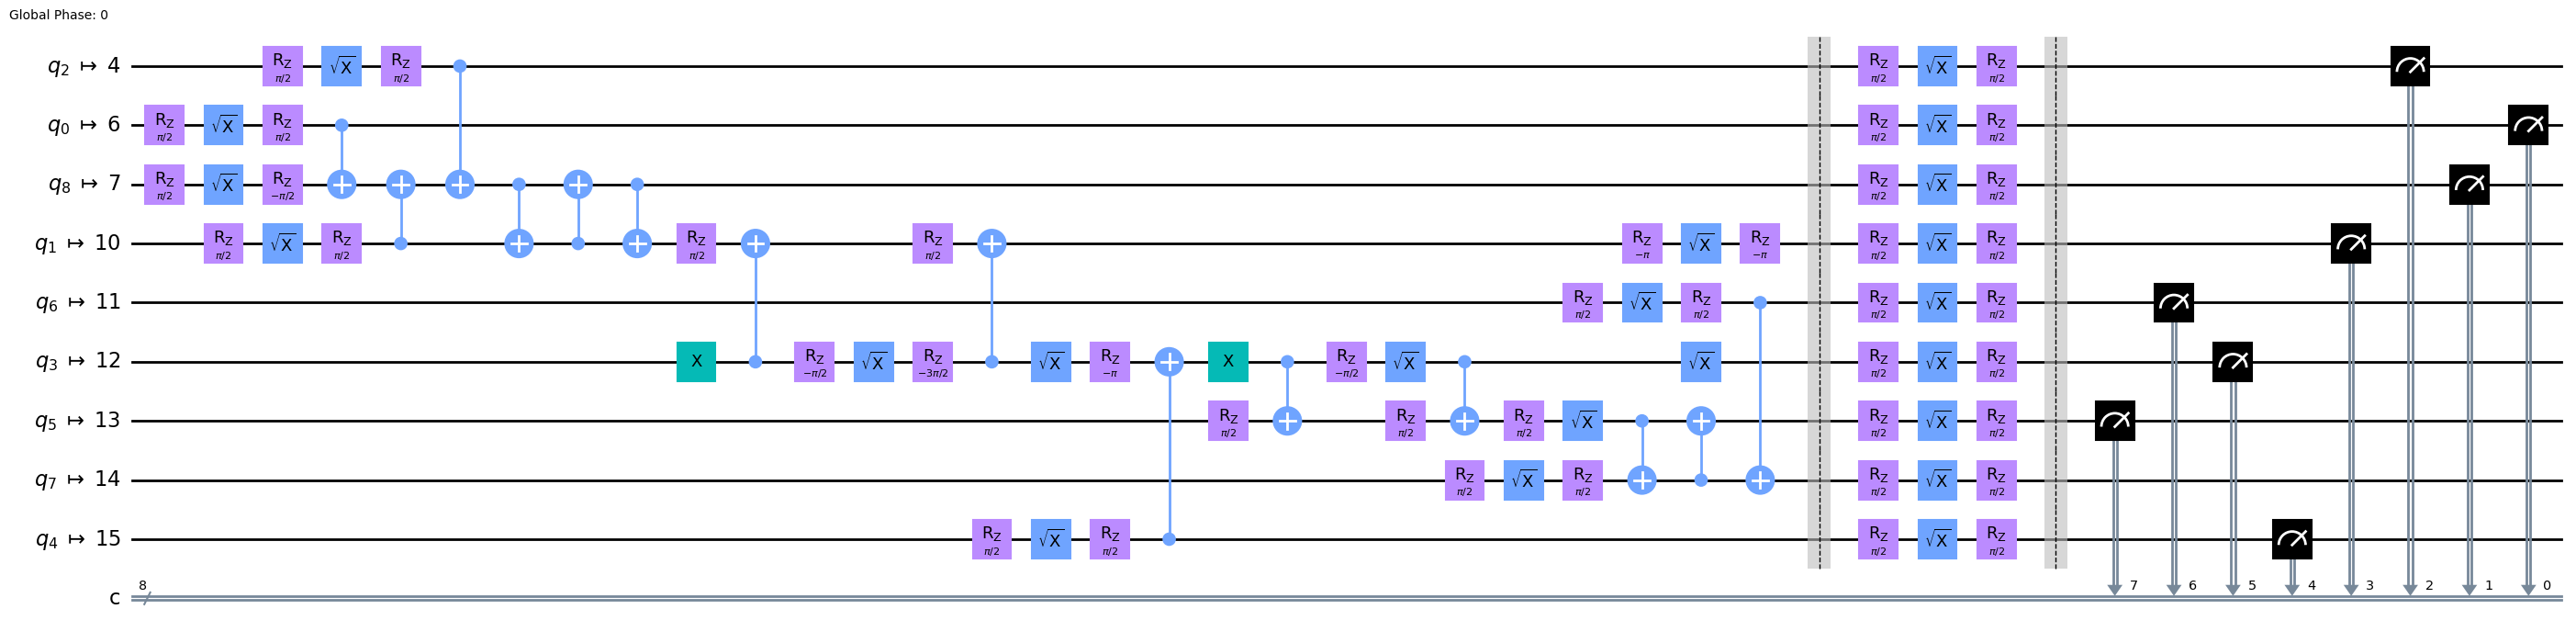

In [16]:
qc_9_optimized = qiskit.transpile(qc_9, ibm_backend, optimization_level=3)
qc_9_optimized.draw("mpl", fold=-1, idle_wires=False, justify="right")

Third, Superstaq optimize with DD:

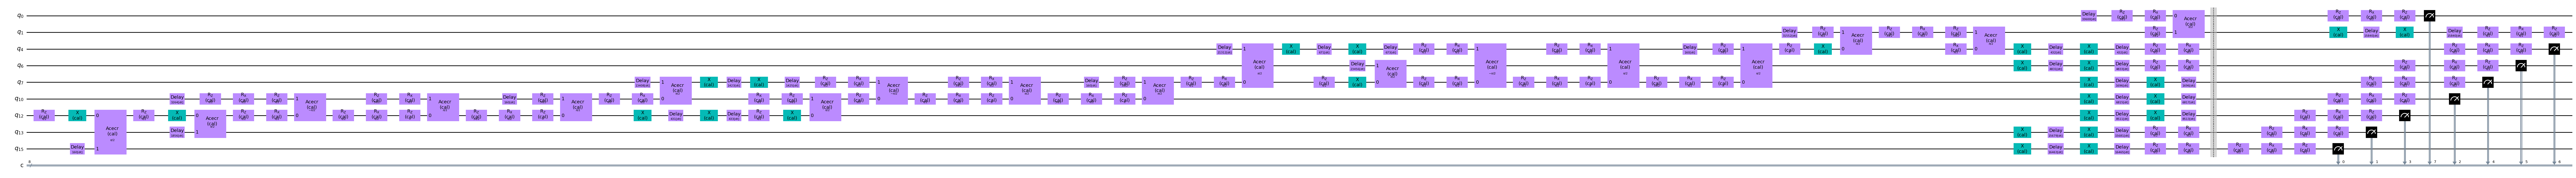

In [17]:
ss_qc_9_optimized = backend.compile(qc_9, dynamical_decoupling=True)
ss_qc_9_optimized.pulse_gate_circuit.draw("mpl", fold=-1, idle_wires=False, justify="right")

Last, real machine run.

In [22]:
job_9 = ibm_backend.run([ss_qc_9_optimized.pulse_gate_circuit,
                         qc_9_optimized], shots=4000)

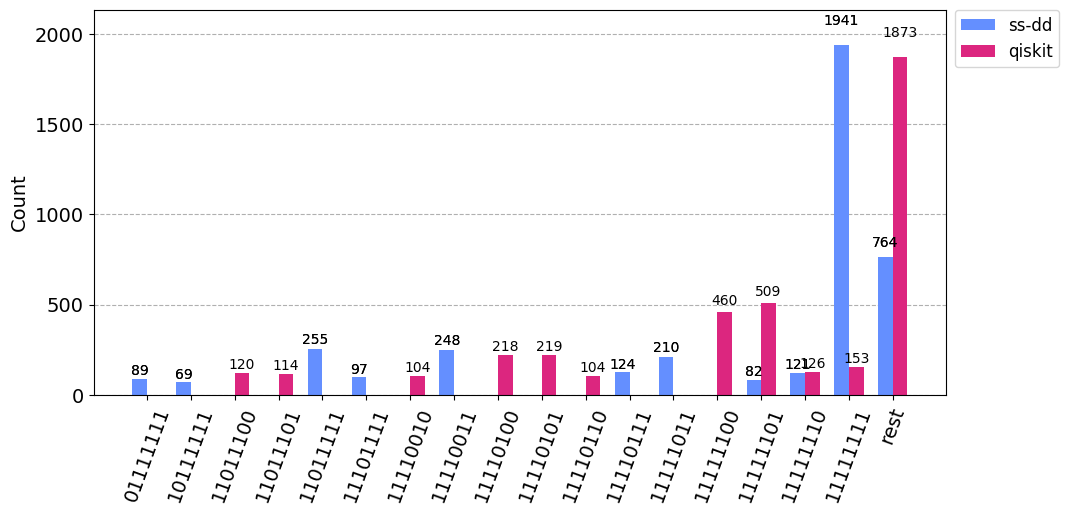

In [19]:
counts_9 = job_9.result().get_counts()
qiskit.visualization.plot_histogram(counts_9, legend=["ss-dd", "qiskit"], 
                                    number_to_keep=10,
                                    figsize=(11, 5))

In this case, Superstaq with DD is once again able to provide outstanding improvement -- more than 12.6x in terms of probability of '11111111' success and about 25.3x in terms of relative strength.